In [3]:
import sys
sys.path.append("../RL-book")
from rl import markov_process
import rl

In [ ]:
Download Pycharm

# Variables and Definitions:

### Set Termonolgy & Symbols

[ ] = set of collection of elements

$A \cup B =$ union of two sets (In A or B)

$A \cap B =$ Intersection of two sets (In A and B)

$A \subseteq B =$ Subset: Every element of A is in B

$A \subset B =$ Proper Subset: every element of A is in B, but B has more elements

$A \not\subset B =$ Not a Subset: A is not a subset of B

$A \supseteq B =$ Superset: A has same elements as B, or more

$A \supset B =$ Proper Subset: A has B's elements and more 

$A \not\supset B =$ Not a Superset: A is not a superset of B

$A^c =$ Compliment: elements not in A

$A - B =$ Difference: in A but not in B

$A = B =$ Equality: both sets have the same members

$A \times B =$ Cartesian Product: {1,2} $\times$ {3,4} = {(1,3), (1,4), (2,3), (2,4)}

$a \in A =$ Element of: a is in A

$b \notin A =$ Not an Element of : b is not in A

$\emptyset =$ Empty set

$\mathbb{U} =$ Universal set

$\mathbb{N}$ = Natural Numbers: Positive int

$\mathbb{Z}$ = Integers

$\mathbb{Q}$ = Rational Numbers

$\mathbb{A}$ = Algebraic Numbers

$\mathbb{R}$ = Real Numbers

$\mathbb{I}$ = Imaginary Numbers

$\mathbb{C}$ = Complex Numbers

### Markov Processes:

$\mathcal{S} =$ Countable set of states known as the State Space

$\mathcal{T} =$ Set of terminal states

$\mathcal{N} =$ Set of Non terminal states

$\mathcal{P} =$ Transition probability function

$\mu:\mathcal{S} \to [0,1] =$ Probability distribution of start states 

# Writing Some Code for Markov Processes:

I'm going to go through the example that is described on page 35 of the textbook

### Stock Price Process:

$X_t =$ The stock price at time t. At each timestep the stock can can go up or down by one.

To understand the random evolution of the stock proces in time, we just need to quanitfy the probability of an up-move $P[X_t+1 = X_t + 1]$

In [9]:
from dataclasses import dataclass
from typing import Optional, Mapping, Sequence, Tuple
from collections import Counter
import numpy as np
from numpy.random import binomial
import itertools
from operator import itemgetter
from rl.gen_utils.common_funcs import get_logistic_func, get_unit_sigmoid_func

######## Process 1: Probability is a LOGISTIC Function ########

#We define an abstract class "Process 1" which has an abstract subclass "State" and has the property "price"
#The process class has parameters level_param and alpha1 which are input parameters for the logistic function
#Process1 has two Methods: up_prob which calculates the LOGISTIC Function and returns a value between 0 and 1
#There is also the method "next_state" which updates the price value in the subclass by either +1 or -1 depending on the 
#probability that up_prob returns

@dataclass
class Process1:
    @dataclass
    class State:
        price: int

    level_param: int  # level to which price mean-reverts
    alpha1: float = 0.25  # strength of mean-reversion (non-negative value)

    def up_prob(self, state: State) -> float:
        return get_logistic_func(self.alpha1)(self.level_param - state.price)

    def next_state(self, state: State) -> State:
        up_move: int = binomial(1, self.up_prob(state), 1)[0]
        return Process1.State(price=state.price + up_move * 2 - 1)


handy_map: Mapping[Optional[bool], int] = {True: -1, False: 1, None: 0}


@dataclass
class Process2:
    @dataclass
    class State:
        price: int
        is_prev_move_up: Optional[bool]

    alpha2: float = 0.75  # strength of reverse-pull (value in [0,1])

    def up_prob(self, state: State) -> float:
        return 0.5 * (1 + self.alpha2 * handy_map[state.is_prev_move_up])

    def next_state(self, state: State) -> State:
        up_move: int = binomial(1, self.up_prob(state), 1)[0]
        return Process2.State(
            price=state.price + up_move * 2 - 1,
            is_prev_move_up=bool(up_move)
        )


@dataclass
class Process3:
    @dataclass
    class State:
        num_up_moves: int
        num_down_moves: int

    alpha3: float = 1.0  # strength of reverse-pull (non-negative value)

    def up_prob(self, state: State) -> float:
        total = state.num_up_moves + state.num_down_moves
        return get_unit_sigmoid_func(self.alpha3)(
            state.num_down_moves / total
        ) if total else 0.5

    def next_state(self, state: State) -> State:
        up_move: int = binomial(1, self.up_prob(state), 1)[0]
        return Process3.State(
            num_up_moves=state.num_up_moves + up_move,
            num_down_moves=state.num_down_moves + 1 - up_move
        )




In [12]:
# A Simple Python program to demonstrate working 
# of yield 
  
# A generator function that yields 1 for the first time, 
# 2 second time and 3 third time 
def simpleGeneratorFun(): 
    yield 1
    yield 2
    yield 3
    
# Driver code to check above generator function 
for value in simpleGeneratorFun():  
    print(value) 

1
2
3


In [10]:
######## Understanding the simulation function ########
#This section will be inportant for understanding the yield function and how that works.
#Yield is used in generator functions and when we want to iterate over a sequece but dont want 
#to store the entire sequence in memory. 

def simulation(process, start_state):
    state = start_state
    while True:
        yield state
        state = process.next_state(state)


def process1_price_traces(
    start_price: int,
    level_param: int,
    alpha1: float,
    time_steps: int,
    num_traces: int
) -> np.ndarray:
    process = Process1(level_param=level_param, alpha1=alpha1)
    start_state = Process1.State(price=start_price)
    return np.vstack([                                   #np.vstack: stacks arrays vertically
        np.fromiter((s.price for s in itertools.islice(  #np.fromiter: creates a 1 dimensional array from an iterable object
            simulation(process, start_state),            #itertools.islice: takes and array and iterates through it given a
            time_steps + 1                                                 #start, stop, and step parameter
        )), float) for _ in range(num_traces)])



def process2_price_traces(
    start_price: int,
    alpha2: float,
    time_steps: int,
    num_traces: int
) -> np.ndarray:
    process = Process2(alpha2=alpha2)
    start_state = Process2.State(price=start_price, is_prev_move_up=None)
    return np.vstack([
        np.fromiter((s.price for s in itertools.islice(
            simulation(process, start_state),
            time_steps + 1
        )), float) for _ in range(num_traces)])


def process3_price_traces(
    start_price: int,
    alpha3: float,
    time_steps: int,
    num_traces: int
) -> np.ndarray:
    process = Process3(alpha3=alpha3)
    start_state = Process3.State(num_up_moves=0, num_down_moves=0)
    return np.vstack([
        np.fromiter((start_price + s.num_up_moves - s.num_down_moves
                    for s in itertools.islice(simulation(process, start_state),
                                              time_steps + 1)), float)
        for _ in range(num_traces)])


def plot_single_trace_all_processes(
    process1_trace: np.ndarray,
    process2_trace: np.ndarray,
    process3_trace: np.ndarray
) -> None:

    from rl.gen_utils.plot_funcs import plot_list_of_curves

    traces_len = len(process1_trace)

    plot_list_of_curves(
        [range(traces_len)] * 3,
        [process1_trace, process2_trace, process3_trace],
        ["r", "b", "g"],
        [
            r"Process 1 ($\alpha_1=0.25$)",
            r"Process 2 ($\alpha_2=0.75$)",
            r"Process 3 ($\alpha_3=1.0$)"
        ],
        "Time Steps",
        "Stock Price",
        "Single-Trace Simulation for Each Process"
    )


def get_terminal_histogram(
    price_traces: np.ndarray
) -> Tuple[Sequence[int], Sequence[int]]:
    pairs = sorted(
        list(Counter(price_traces[:, -1]).items()),
        key=itemgetter(0)
    )
    return [x for x, _ in pairs], [y for _, y in pairs]


def plot_distribution_at_time_all_processes(
    process1_traces: np.ndarray,
    process2_traces: np.ndarray,
    process3_traces: np.ndarray
) -> None:

    from rl.gen_utils.plot_funcs import plot_list_of_curves

    num_traces = len(process1_traces)
    time_steps = len(process1_traces[0]) - 1

    x1, y1 = get_terminal_histogram(process1_traces)
    x2, y2 = get_terminal_histogram(process2_traces)
    x3, y3 = get_terminal_histogram(process3_traces)

    plot_list_of_curves(
        [x1, x2, x3],
        [y1, y2, y3],
        ["r", "b", "g"],
        [
            r"Process 1 ($\alpha_1=0.25$)",
            r"Process 2 ($\alpha_2=0.75$)",
            r"Process 3 ($\alpha_3=1.0$)"
        ],
        "Terminal Stock Price",
        "Counts",
        f"Terminal Price Counts (T={time_steps:d}, Traces={num_traces:d})"
    )



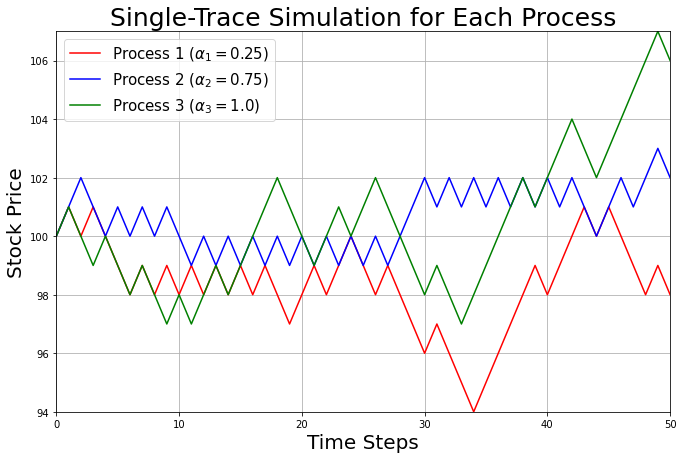

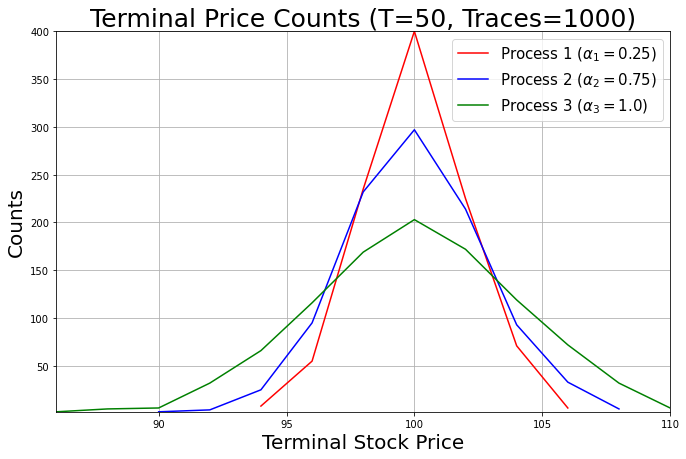

In [15]:

if __name__ == '__main__':
    start_price: int = 100
    level_param: int = 100
    alpha1: float = 0.25
    alpha2: float = 0.75
    alpha3: float = 1.0
    time_steps: int = 50
    num_traces: int = 1000

    process1_traces: np.ndarray = process1_price_traces(
        start_price=start_price,
        level_param=level_param,
        alpha1=alpha1,
        time_steps=time_steps,
        num_traces=num_traces
    )
    process2_traces: np.ndarray = process2_price_traces(
        start_price=start_price,
        alpha2=alpha2,
        time_steps=time_steps,
        num_traces=num_traces
    )
    process3_traces: np.ndarray = process3_price_traces(
        start_price=start_price,
        alpha3=alpha3,
        time_steps=time_steps,
        num_traces=num_traces
    )

    trace1 = process1_traces[0]
    trace2 = process2_traces[0]
    trace3 = process3_traces[0]

    plot_single_trace_all_processes(trace1, trace2, trace3)

    plot_distribution_at_time_all_processes(
        process1_traces,
        process2_traces,
        process3_traces
    )


# Finite Markov Process